In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


In [2]:

# Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 35


In [3]:

# Paths
train_dir = "data/train"
val_dir = "data/val"


In [5]:

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Load DenseNet201 base
base_model = DenseNet201(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # freeze base layers

# Custom top layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.25)(x)
output = Dense(train_gen.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
callbacks = [
    EarlyStopping(patience=8, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.3, patience=4, verbose=1),
    ModelCheckpoint("best_densenet201_model.keras", save_best_only=True)
]


Found 33984 images belonging to 4 classes.
Found 6400 images belonging to 4 classes.


In [6]:

# Train
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks
)


Epoch 1/35


c:\Users\molim\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1062/1062 ━━━━━━━━━━━━━━━━━━━━ 1204s 1s/step - accuracy: 0.3264 - loss: 1.4946 - val_accuracy: 0.5392 - val_loss: 1.0333 - learning_rate: 1.0000e-04
Epoch 2/35
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 1034s 972ms/step - accuracy: 0.4377 - loss: 1.2093 - val_accuracy: 0.5683 - val_loss: 0.9411 - learning_rate: 1.0000e-04
Epoch 3/35
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 1044s 981ms/step - accuracy: 0.4659 - loss: 1.1484 - val_accuracy: 0.5566 - val_loss: 0.9159 - learning_rate: 1.0000e-04
Epoch 4/35
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 1058s 994ms/step - accuracy: 0.4899 - loss: 1.1177 - val_accuracy: 0.5569 - val_loss: 0.8885 - learning_rate: 1.0000e-04
Epoch 5/35
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 1043s 981ms/step - accuracy: 0.5012 - loss: 1.0908 - val_accuracy: 0.5811 - val_loss: 0.8835 - learning_rate: 1.0000e-04
Epoch 6/35
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 1064s 1s/step - accuracy: 0.5113 - loss: 1.0693 - val_accuracy: 0.5792 - val_loss: 0.8799 - learning_rate: 1.0000e-04
Epoch 7/35
1062/1062 ━━━━━━━━━━━━━━━━━━

In [7]:

# Evaluate
loss, acc = model.evaluate(val_gen)
print(f"Validation Accuracy: {acc * 100:.2f}%")


200/200 ━━━━━━━━━━━━━━━━━━━━ 170s 850ms/step - accuracy: 0.6613 - loss: 0.8012
Validation Accuracy: 66.81%


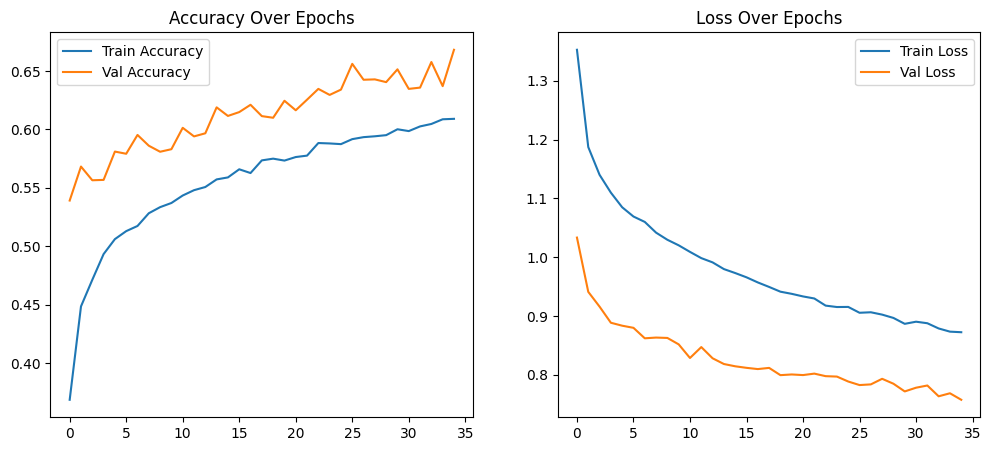

In [8]:

# Plotting
def plot_history(hist):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(hist.history['accuracy'], label='Train Accuracy')
    plt.plot(hist.history['val_accuracy'], label='Val Accuracy')
    plt.legend()
    plt.title("Accuracy Over Epochs")

    plt.subplot(1,2,2)
    plt.plot(hist.history['loss'], label='Train Loss')
    plt.plot(hist.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title("Loss Over Epochs")

    plt.show()

plot_history(history)


In [9]:
model.save("alzheimernet_model_densenet201.keras")


In [10]:
from tensorflow import keras
model = keras.models.load_model("alzheimernet_model_densenet201.keras")
